# Construccion de corpus

In [ ]:
import os
from bs4 import BeautifulSoup

libros_baum = [
    "the wonderful wizard of oz", "the marvelous land of oz", "ozma of oz",
    "dorothy and the wizard in oz", "the road to oz", "the emerald city of oz",
    "the patchwork girl of oz", "tik-tok of oz", "the scarecrow of oz",
    "rinkitink in oz", "the lost princess of oz", "the tin woodman of oz",
    "the magic of oz", "glinda of oz"
]

libros_thompson = [
    "the royal book of oz", "kabumpo in oz", "the cowardly lion of oz",
    "grampa in oz", "the lost king of oz", "the hungry tiger of oz",
    "the gnome king of oz", "the giant horse of oz", "jack pumpkinhead of oz",
    "the yellow knight of oz", "pirates in oz", "the purple prince of oz",
    "ojo in oz", "speedy in oz", "the wishing horse of oz", "captain salt in oz",
    "handy mandy in oz", "the silver princess in oz", "ozoplaning with the wizard of oz"
]

def limpiar_titulo(nombre_archivo):
    base = os.path.splitext(nombre_archivo)[0]
    base = base.replace("_", " ").replace("-", " ").lower()
    return base.strip()

carpeta = "../../datos/libros_oz"
salida = "capitulos_autor.txt"

def limpiar_texto(texto):
    return ' '.join(texto.split())

# Procesamiento
with open(salida, "w", encoding="utf-8") as fout:
    for archivo in os.listdir(carpeta):
        if archivo.endswith(".html"):
            ruta = os.path.join(carpeta, archivo)
            titulo_limpio = limpiar_titulo(archivo)
            titulo_limpio = titulo_limpio[:-31]
            # Determinar autor según listas
            if titulo_limpio in libros_baum:
                autor = "baum"
            elif titulo_limpio in libros_thompson:
                autor = "thompson"
            else:
                autor = "desconocido"
                print("Desconocido:", titulo_limpio)

            if autor != "desconocido":
                with open(ruta, "r", encoding="utf-8") as f:
                    soup = BeautifulSoup(f, "html.parser")

                    capitulos = soup.find_all("span", class_="mw-headline")
                    capitulos = [c for c in capitulos if "chapter" in c.get_text(strip=True).lower()]


                    for cap in capitulos:
                        contenido = []
                        siguiente = cap.parent.find_next_sibling()
                        while siguiente and not (siguiente.name in ["h2", "h3"] or "mw-headline" in siguiente.get("class", [])):
                            texto = siguiente.get_text(separator=" ", strip=True)
                            if texto:
                                contenido.append(texto)
                            siguiente = siguiente.find_next_sibling()

                        if contenido:
                            texto_linea = limpiar_texto(' '.join(contenido))
                            fout.write(f"{autor} | {texto_linea}\n")
                        else:
                            print(f"⚠️ Capítulo vacío en {archivo}: {cap.get_text(strip=True)}")


Desconocido: the shaggy man of oz
Desconocido: the wonderful wizard of oz (book)
Desconocido: the woggle bug book
Desconocido: tik tok of oz
Desconocido: the magical mimics in oz


# Preprocesamiento

In [12]:
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
import string
import re

# Define preprocessing function
def preprocess(text, stemmer, stop_words):
    # Lowercase
    text = text.lower()
    # Remove punctuation and numbers
    text = re.sub(r'[\d]+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize
    tokens = text.split()
    # Remove stopwords and stem
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words and len(word) >= 2]
    return ' '.join(tokens)

In [14]:
stemmer = SnowballStemmer("english")  # Or "spanish" if your texts are in Spanish
stop_words = set(stopwords.words("english"))

## Visualizacion

In [ ]:
renglones = []
y = []
with open("capitulos_autor.txt", "r", encoding="utf-8") as f:
    for linea in f:
        partes = linea.strip().split(" | ")
        if len(partes) == 2:
            autor, texto = partes
            texto_procesado = preprocess(texto, stemmer, stop_words)
            renglones.append(texto_procesado)
            y.append(autor)

vectorizer = CountVectorizer(max_features=5000, min_df=1)
X = vectorizer.fit_transform(renglones)
y = [1 if autor == "baum" else 0 for autor in y]  # 1 para Baum, 0 para Thompson

Dimensión de la matriz: (384, 5000)
Palabras (vocabulario): ['aback' 'abandon' 'abdic' 'abid' 'abl' 'ablebodi' 'aboard' 'about'
 'abroad' 'abrog']


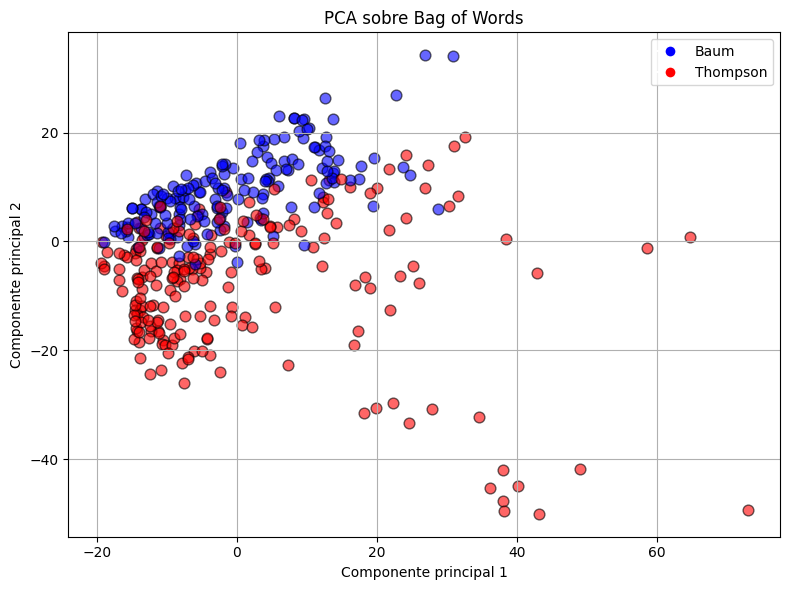

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

plt.figure(figsize=(8, 6))
colores = ['red' if label == 0 else 'blue' for label in y]
etiquetas = ['Thompson' if label == 0 else 'Baum' for label in y]

for xi, yi, color, etiqueta in zip(X_pca[:, 0], X_pca[:, 1], colores, etiquetas):
    plt.scatter(xi, yi, c=color, label=etiqueta, alpha=0.6, edgecolors='k', s=60)

handles = [plt.Line2D([0], [0], marker='o', color='w', label='Baum', markerfacecolor='blue', markersize=8),
           plt.Line2D([0], [0], marker='o', color='w', label='Thompson', markerfacecolor='red', markersize=8)]
plt.legend(handles=handles)

plt.title("PCA sobre Bag of Words")
plt.xlabel("Componente principal 1")
plt.ylabel("Componente principal 2")
plt.grid(True)
plt.tight_layout()
plt.show()


## Entrenamiento y evaluacion de modelos

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import numpy as np

renglones = []
etiquetas = []
with open("capitulos_autor.txt", "r", encoding="utf-8") as f:
    for linea in f:
        partes = linea.strip().split(" | ")
        if len(partes) == 2:
            autor, texto = partes
            texto_procesado = preprocess(texto, stemmer, stop_words)
            if texto_procesado.strip():
                renglones.append(texto_procesado)
                etiquetas.append(1 if autor == "baum" else 0)

modelos = {
    "SVM": LinearSVC(),
    "Regresión Logística": LogisticRegression(max_iter=1000),
    "Árbol de Decisión": DecisionTreeClassifier()
}

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
resultados = {nombre: [] for nombre in modelos}

for fold, (train_idx, test_idx) in enumerate(kf.split(renglones, etiquetas), start=1):
    X_train_text = [renglones[i] for i in train_idx]
    X_test_text = [renglones[i] for i in test_idx]
    y_train = [etiquetas[i] for i in train_idx]
    y_test = [etiquetas[i] for i in test_idx]

    vectorizer = CountVectorizer(max_features=5000, min_df=1)
    X_train = vectorizer.fit_transform(X_train_text)
    X_test = vectorizer.transform(X_test_text)

    for nombre, modelo in modelos.items():
        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        resultados[nombre].append(acc)

print("Accuracy promedio:")
for nombre, scores in resultados.items():
    print(f"{nombre}: {np.mean(scores):.4f}")

/home/juancho/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/juancho/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy promedio:
SVM: 0.9974
Regresión Logística: 0.9974
Árbol de Decisión: 0.9219
